# 多腕バンデッド問題


確率p で 1 を、1-p で 0 を返すスロットマシンを考えます。（このような分布をベルヌーイ分布といいます。）
そのようなスロットマシンが10 台あるとします。ただし、それぞれの p は分からないとします。
スロットマシンを合計 10000 回引くチャンスが与えられたとして，できるだけ高い得点を得る思考ルーチンを作成しましょう。

この多腕バンディット問題は、ジレンマを抱えた問題です。いろんなスロットマシンを引いてみないと、どれがいいスロットマシンか分かりません。いいスロットマシンだと思ったら、それを優先的に引くべきですが、今までの結果がたまたまかもしれないので、今まで調子が悪かったらといって、全く顧みないのでは良くないです。最初は，どれの確率が高いか分からないので，プレーしながら勉強していくしかありません。

全体の回数は 10000 回としましたが，この値によって，戦略は違ってくるでしょう。
また，p の値は分からなくても，その分布に関する情報があると状況が変わってきます。
例えば，p の値は 1 か 0 しかとらないということが分かっていれば，一度当たったのはずっと引き続ければいいし，一度外れたものをもう一度引くことはないというのが戦略となるでしょう。
ここでは，p の分布は [0, 1] の一様分布 (Math.random() で与えられるもの) とします。

Bandit はスロットマシンのクラス(p というインスタンス変数に確率をもっています)
MultiArmedBandit は，そのようなスロットマシン 10 台集まったもの（多腕バンデット）のクラスです。インスタンス変数 bandits にBandit のリストを持っています。update は，今は使いません。


In [1]:
import random
class Bandit:
    '''スロットマシン  確率 p で  1, 1-p で 0 を返す （ベルヌーイ分布）'''
    def __init__(self):
        self.p = random.uniform(0,1)

    def slot(self):
        if (random.uniform(0,1) <  self.p):
            return 1
        else:
            return 0

    def update(self):
        '''1/2 の確率で，0.05 上げるか下げるか。 \
        0 または 1 になったらそれ以上は動かさない。'''
        if(random.uniform(0,1) < 0.5):
            self.p = max(self.p - 0.05, 0)
        else:
            self.p = min(self.p + 0.05, 1)

class MultiArmedBandit:
    NUM= 10;   #スロットマシンの個数
    def __init__(self):
        self.bandits = [Bandit() for i in range(MultiArmedBandit.NUM)]

    def slot(self,i):
        '''i 番目のスロットマシンを引く'''
        if (i < 0 or i >= MultiArmedBandit.NUM):
            return 0
        return self.bandits[i].slot()

    def update(self):
        '''全ての確率を更新。今は使用しない。'''
        for b in self.bandits:
            b.update()

    def getmax(self):
        return max([x.p for x in self.bandits])


MultiArmedBandit を一つ作って，m に代入します。

In [2]:
m = MultiArmedBandit()

各スロットマシンの確率は，次のようにして見ることができます。ただし，これを見るのは実験段階では構いませんが，思考ルーチンで，これを使ったプログラムを書いてはいけません。

In [3]:
print([f"{x.p:2.2f}" for x in m.bandits])

['0.95', '0.22', '0.85', '0.69', '0.17', '0.49', '0.53', '0.71', '0.11', '0.01']


1 回づつ引いてみましょう。

In [4]:
for i in range(10):
    print(m.slot(i))

0
0
1
1
0
1
0
1
1
0


思考ルーチンを作ることを考えます。思考ルーチンは，次の 3 つのメソッドからなるものとします。

choice():  次どれを引くか番号を返す。

learn(k, result): k を引いた結果 result だったということを学習する。

reset():  今までの学習結果を忘れて，最初から学習を行う。

この３つのメソッドを持つクラスを作りましょう。例えば，何も学習せずに，乱数を発生させて，ランダムに引くのは次のようなものです。


In [5]:
class RandomStrategy:
    def learn(self,k, result):
        return

    def choice(self):
        return random.randrange(MultiArmedBandit.NUM);

    def reset(self):
        return



また，前にひいたのが当たったら，またそれを引く。そうでないときには，次のをひく（最後までいったら最初に戻る）というのは，次のようになります。


In [6]:
class TsuikiStrategy:
    def __init__(self):
        self.my = 0
    def learn(self, k, result):
        if (result == 1):
            self.my = self.my;
        else:
            self.my = (self.my + 1)% MultiArmedBandit.NUM

    def choice(self):
        return self.my

    def reset(self):
        self.my = 0

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def MABTest(numplay, strategy, mab, change=False):
    '''numplay 回数だけ，str ストラテジーで mab multi-armed bandit 
    から引いて当たった回数を表示する'''
    total = [0]*10
    atari = [0]*10
    myaccount = 0
    for i in range(numplay):
        k = strategy.choice();   # str に聞いて
        result = mab.slot(k);   # 言われたスロットをひいて
        total[k] += 1
        atari[k] += result
        myaccount += result;    # 結果だけ account を増やす (0 か 1)
        strategy.learn(k,result);     #k を引いて結果が result だったことを str に学習させる
        if(change):
            mab.update()   # 確率を毎回変化させるには，このコメントをはずす。
    print(f"{numplay} 中 {myaccount}回あたり")   

    fig, ax1 = plt.subplots()
    ax1.plot([x.p for x in mab.bandits], color="red")
    ax1.set_ylim(0,1)
    ax2 = ax1.twinx()  # 2つのプロットを関連付ける
    ax2.plot(atari)
    ax2.plot(total)
    ax2.set_ylim(0,10000)
#        print([f"{x.p:2.2}" for x in m.bandits])
#    print([f"{atari[x]:4}" for x in range(10)])
#    print([f"{total[x]:4}" for x in range(10)])

10000 中 8027回あたり


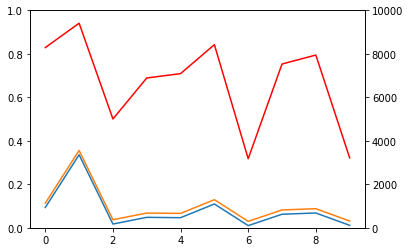

In [8]:
m = MultiArmedBandit()
s = TsuikiStrategy()
MABTest(10000, s, m)


10000 中 4746回あたり
10000 中 8480回あたり
10000 中 6359回あたり
10000 中 6795回あたり
10000 中 6943回あたり
10000 中 8047回あたり
10000 中 6313回あたり
10000 中 7702回あたり
10000 中 8663回あたり
10000 中 9112回あたり


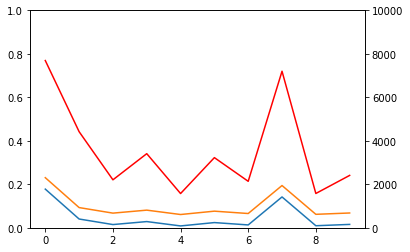

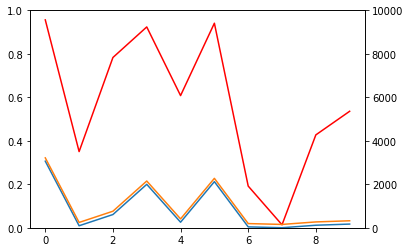

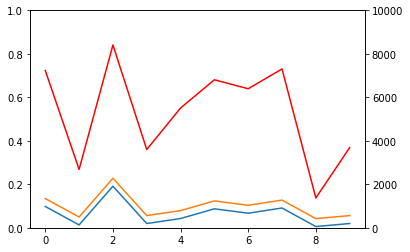

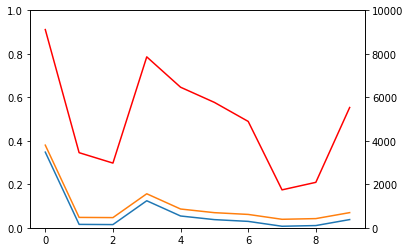

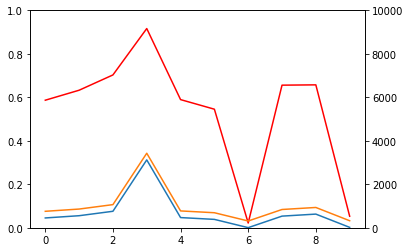

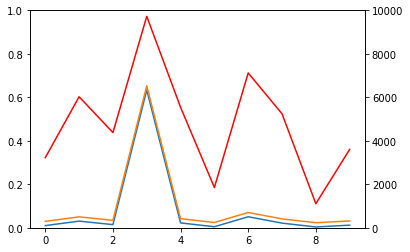

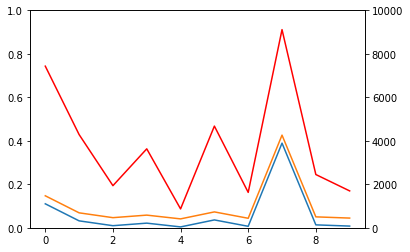

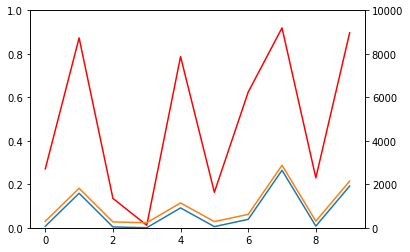

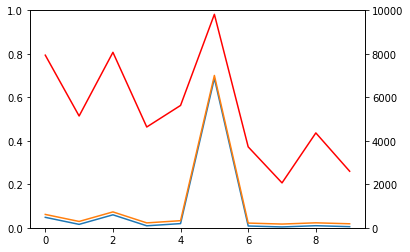

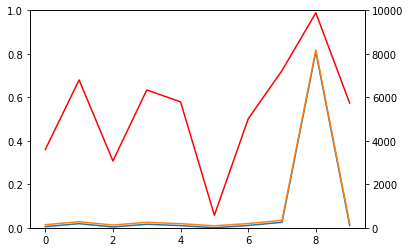

In [9]:
  
for i in range(10):
    MABTest(10000, TsuikiStrategy(), MultiArmedBandit()) 

**練習問題** コンスタントに同じ(例えば0 番)を引くという strategy を作り，RandomStrategy と TsuikiStrategy と３つの strategy を比較しよう。それぞれ，どのような性質を持っているか。それぞれ，どういう時に有効か。また，どういう目的の時にhどの Strategy を使ったらよさそうか。


**練習問題** strategy の良さは，何を目標とするかで変わってくると考えられる。10 回の試行ではなく，1000回試行し，その結果の値の平均と分散を計算しよう。また，その分布をグラフで視覚化しよう。

**練習問題** 自分の strategy を作ろう。それを，"自分の名前"+Strategy という名前のクラスにし，
自分の名前.py というファイルに作ろう。それを，来週までに PandA の課題に提出すること。来週，strategy の競争を行う。
次回（12 回）のプリントや，ネットから得られる情報は見ないで，自分で考えよう。

以下は，来週，競争に使うプログラム。10000 回引くのを１プレイとして，同じ MAB に対してプレイした時の当たった確率で，何回か(次の例では10 回)競う。

In [10]:
import numpy as np

def OnePlay(numplay, strategies, mab, change=False):
    '''ndarray として返す。'''
    myaccounts = np.zeros(len(strategies), dtype=int)
    for x in strategies:
        x.reset()

    for i in range(numplay):
        for s in range(len(strategies)):
            k = strategies[s].choice() 
            result = mab.slot(k)   
            myaccounts[s] += result 
            strategies[s].learn(k,result)  
        if(change):
            mab.update()  # 確率が変化していく場合
    return(myaccounts/numplay)  

def MultiMABTester(n, strategies, change=False):
    NUMPLAY = 10000
    ret = np.zeros((len(strategies),0))
    print(ret.shape)
    
    for i  in range(n):
        mab = MultiArmedBandit()
        ret = np.append(ret, OnePlay(NUMPLAY, strategies, mab, change).reshape(len(strategies),1), axis=1)
    return ret


(2, 0)


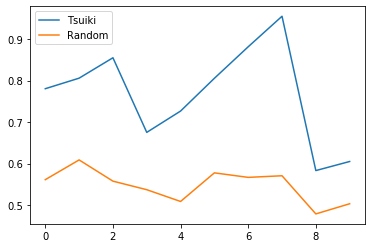

In [11]:
names = ["Tsuiki", "Random"]
ret = MultiMABTester(10, [TsuikiStrategy(),RandomStrategy()])
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
for i in range(len(names)):
    plt.plot(ret[i], label=names[i])
# rs は、red, square
plt.legend(loc='upper left')

**練習問題** 上の MABTester, および，MultiMABTester に，change=True という引数を渡すと，毎回，全てのスロットの確率が 1/2 の確率で 0.05 づつ上がるか下がるかするようになる。
（ただし，確率が 0 より小さく，または大きくならない）
この設定のもとで，戦略プログラムを組んでみよう。


(4, 0)


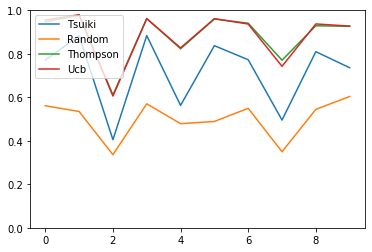

In [26]:
names = ["Tsuiki", "Random", "Thompson", "Ucb"]
ret = MultiMABTester(10, [TsuikiStrategy(),
                          RandomStrategy(),
                          ThompsonStrategy(), 
                          UcbStrategy()], 
                     change=False)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_ylim(0,1)
for i in range(len(names)):
    plt.plot(ret[i], label=names[i])
# rs は、red, square

ax1.legend(loc='upper left')


In [20]:
len(names)

4

In [16]:
import math
'''Xj + c sqrt(2 log n / nj)  for c = 100'''

class UcbStrategy:
    def __init__(self,cc = 0.16):
        self.totalnum = 1
        self.expectedValues = [0]*MultiArmedBandit.NUM
        self.numtosses = [0]*MultiArmedBandit.NUM
        self.c = cc;  #c == 14 is the best in my experiment!!, 
                        #with the average 0.869

    def learn(self,i, result):
        self.totalnum += 1
        self.numtosses[i] += 1;
        if (result == 1):
            self.expectedValues[i] += 1;

    def choice(self):
        ind = 0;
        maxv = 0;
        for i in range(MultiArmedBandit.NUM):
            k =self.expectedValues[i]/(self.numtosses[i]+0.01) + \
            self.c * math.sqrt(2 * math.log(self.totalnum) / (self.numtosses[i]+0.01))
            if (k > maxv):
                maxv = k
                ind = i
        return ind;

    def reset(self):
        self.totalnum = 1;
        self.expectedValues = [0] * MultiArmedBandit.NUM
        self.numtosses = [0] * MultiArmedBandit.NUM


10000 中 9604回あたり


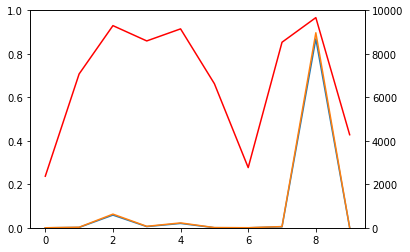

In [27]:
m = MultiArmedBandit()
s = UcbStrategy(0.3)
MABTest(10000, s, m)

In [22]:
class ThompsonStrategy:
    def __init__(self):
        self.total = [0]*10
        self.atari = [0]*10
        
    def learn(self, k, result):
        self.total[k] += 1
        self.atari[k] += result        

    def choice(self):
        betas = [np.random.beta(self.atari[k]+1,self.total[k]-self.atari[k]+1) for k in range(10)]
        return betas.index(max(betas))

    def reset(self):
        self.total = [0]*10
        self.atari = [0]*10        
        

10000 中 7754回あたり


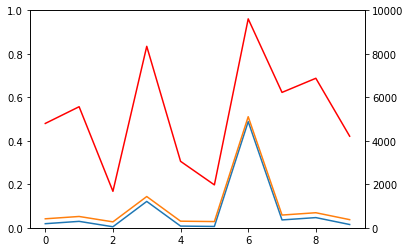

In [23]:
m = MultiArmedBandit()
s = TsuikiStrategy()
MABTest(10000, s, m)